In [30]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import os
from scipy import stats

In [3]:
def ReadData(fileLocation):
    #read data in relation to format
    try:
        if fileLocation.endswith('.csv'): 
            dataRead =pd.DataFrame(pd.read_csv(fileLocation,delimiter = " "))
            dataRead.columns = ['X','Y','Z']
        elif fileLocation.endswith('.tsv'): 
            dataRead = np.genfromtxt(fileLocation, delimiter = " " )
            x = dataRead[:,0]
            y= dataRead[:,1]
            z =dataRead[:,2]
            dataRead = pd.DataFrame({'X':x,'Y':y, 'Z':z})
        elif fileLocation.endswith('.xls'):
            dataRead = pd.read_excel(fileLocation)
        elif fileLocation.endswith('.txt'):
            dataRead =pd.read_csv(fileLocation, sep=' ')
            dataRead.columns = ['X','Y','Z']
           
        else:
            # Unsupported file format
            raise ValueError(f"Unsupported file format: {fileLocation}")
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    return dataRead



In [4]:
#looking for the max directly
def DirectMaxSearch(Voltage):
    maxIndex = np.argmax(Voltage)
    return maxIndex

In [22]:
def gaussian_2d(xy, a, mu_x, mu_y, sigma_x, sigma_y):
    #Calculates the 2D Gaussian function value for given x and y
    x, y = xy
    return a * np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

def fit_gaussian_2d(x, y, z):
    # Fits a 2D Gaussian curve to the given data points and finds the maximum position.
    # then returns a tuple containing the x and y positions of the maximum value.

    # Smooth the z data 
    z_smoothed = gaussian_filter(z, sigma=1)

    # Flatten the data for fitting
    x_flat = x.ravel()
    y_flat = y.ravel()
    z_flat = z_smoothed.ravel()

    # Improved initial guess
    a = np.max(z_flat)
    initial_guess = (a, np.mean(x_flat), np.mean(y_flat), np.std(x_flat), np.std(y_flat))

    try:
        # Perform curve fitting
        popt, pcov = curve_fit(gaussian_2d, (x_flat, y_flat), z_flat, p0=initial_guess)
        peak_gaussian_x = popt[1]  # Extract the x-position of the maximum
        peak_gaussian_y = popt[2]  # Extract the y-position of the maximum
        return (peak_gaussian_x, peak_gaussian_y)
    except RuntimeError:
        print("Curve fitting failed")
        return None

In [29]:


def analyze_dataset(dataset, count, index):
    voltage = dataset["Z"]
    y_value = dataset["Y"]
    x_value = dataset["X"]

    # Convert to numpy arrays
    x_flat = x_value.to_numpy()
    y_flat = y_value.to_numpy()
    voltage_flat = voltage.to_numpy()

    # Direct Max analysis
    dir_max_index = np.argmax(voltage_flat)
    dir_max_posX = x_flat[dir_max_index]
    dir_max_posY = y_flat[dir_max_index]
    dir_max_val = np.max(voltage_flat)
    dir_max_data = (dir_max_posX, dir_max_posY, dir_max_val)

    print(f"For this dataset, direct max X position is: {dir_max_posX}, direct max Y position is: {dir_max_posY}, and value is: {dir_max_val}")

    # Gaussian max analysis
    gauss_max_posX, gauss_max_posY = fit_gaussian_2d(x_flat, y_flat, voltage_flat)

    if gauss_max_posX is not None and gauss_max_posY is not None:
        gauss_max_val = gaussian_2d((gauss_max_posX, gauss_max_posY), np.max(voltage_flat), gauss_max_posX, gauss_max_posY, np.std(x_flat), np.std(y_flat))
        gauss_max_data = (gauss_max_posX, gauss_max_posY, gauss_max_val)
        print(f"For this dataset, Gaussian max X position is: {gauss_max_posX}, Y position is: {gauss_max_posY}, and value is: {gauss_max_val}")
    else:
        print("Gaussian fit failed for this dataset.")
        gauss_max_data = (None, None, None)

    # Plot the data
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(x_flat, y_flat, voltage_flat)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Voltage")
    ax.set_title(f"{count} {index}")
    plt.show()

    return dir_max_data, gauss_max_data

For this dataset, direct max X position is: 11.740355, direct max Y position is: 11.12429, and value is: 0.1880720311253
For this dataset, Gaussian max X position is: 11.73991939109303, Y position is: 11.123378528693799, and value is: 0.1880720311253


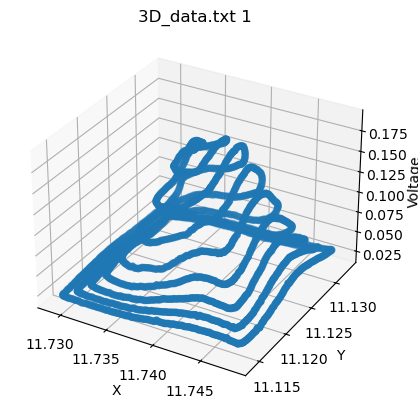

In [24]:
#declare 2 arrays that will hold the data from the anaylyse_dataset function
dir_results = []
gauss_results =[]
directory_path ="3D_data"
index = 1 #to help identify the index of the file we are currently processing

#loop through the data set folder and perform all the necessary operations(read the data, process the maxima etc)

for file_name in os.listdir(directory_path): #get a single dataset at a time (identified by file_name)
    file_path = os.path.join(directory_path, file_name)
    data = ReadData(file_path)
    if data is not None:
        direct, gauss = analyze_dataset(data,file_name,index) #analyse dataset and return a tuple containind the direct max data and the gaussian max data
       
        #add the results to an array containing the results from other datasets
        dir_results.append(direct)
        gauss_results.append(gauss)
        index +=1


In [25]:
# Storing Gaussian results in a CSV file
df_gauss = pd.DataFrame(gauss_results)
df_gauss.to_csv("gaussianData.csv", index=False)  # Store Gaussian max data in gaussianData.csv

# Storing Direct Max results in a CSV file
df_dir = pd.DataFrame(dir_results)
df_dir.to_csv("directData.csv", index=False)  # Store direct max data in directData.csv

In [26]:
from mpl_toolkits.mplot3d import Axes3D

def read_and_process_final_datasets(fileName):
    # Read the data from the file
    df = pd.read_csv(fileName, delimiter=",")
    
    # Ensure the DataFrame has the expected columns
    df.columns = ["x", "y", "z"]
    
    # Extract columns
    volt = df["z"]
    y_val = df["y"]
    x_val = df["x"]
    
    # Plot the data
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(x_val, y_val, volt)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Voltage")
    ax.set_title("Final dataset")
    plt.grid()
    plt.show()
    
    #displaying the best fitline graph
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x_val, volt)
    
    # # Create the best fit line function
    # def best_fit_line(x):
    #     return slope * x + intercept
    # # Generate x values for the best fit line
    # x_fit = np.linspace(min(x_val), max(x_val), 100)  # Adjust the range of x_fit as needed
    # # Plot the best fit line
    # plt.plot(x_fit, best_fit_line(x_fit), color='red')
    # plt.title("Scatter Plot of Maximum x-values against Maximum Voltage with Best Fit Line ")
    # plt.show()


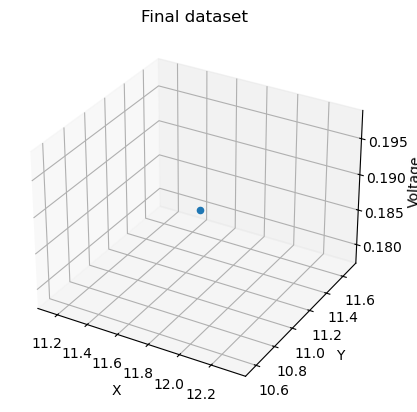

In [27]:
#direct final maximum data and position plot
read_and_process_final_datasets("directData.csv",)

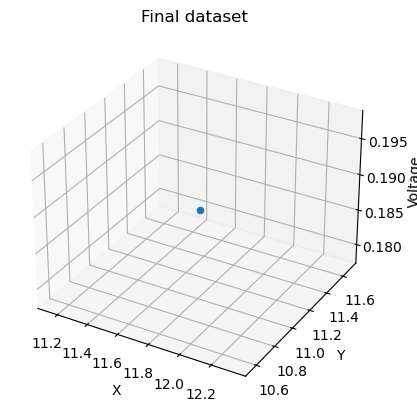

In [28]:
#guassian final maximum data and position plot
read_and_process_final_datasets("gaussianData.csv")